# Assignment 4 CS 5316 Natural Language Processing

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !unzip "/content/drive/My Drive/Colab Notebooks/msr_paraphrase.zip"

Archive:  /content/drive/My Drive/Colab Notebooks/msr_paraphrase.zip
  inflating: msr_paraphrase_test.txt  
  inflating: msr_paraphrase_train.txt  


In [0]:
# d = "50"
# !cp "/content/drive/My Drive/Colab Notebooks/glove_6B/glove.6B.50d.txt" "glove.6B.50d.txt"

In [0]:
import numpy as np
from IPython.display import Image
# Get the interactive Tools for Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from nltk import ngrams
import pandas as pd
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, RepeatVector,Flatten, TimeDistributed, Input,Bidirectional,LocallyConnected1D,Conv1D,GlobalAveragePooling1D,GlobalMaxPooling1D,Concatenate,BatchNormalization
from tensorflow.keras.layers import Embedding, LSTM ,Dropout, SimpleRNN, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
# import tensorflow.keras.utils.to_categorical as to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import math
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report

# Final Assingmnet
This is going to be the final assignment for deep learning. Here is a very good visual for what you will be doing with
<a href="https://ibb.co/mh9Ks0j">deep learning.</a> Lets get started.......

# TASK 1 Paraphrase Detection
For this task we will be using the [ Microsoft Research Paraphrase Corpus ](https://www.microsoft.com/en-us/download/details.aspx?id=52398). The corpus consist of sentence pairs with 1 or 0 labels which identify if the sentences are paraphrase or not respectively.
<br>
To perform this task we will be using recurrenct neural network for this task specifically the [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). RNN can be architected in multiple ways. Some of the possible ways are as follows:
<img src="archetecturernn.PNG">
The box in the bottom is the input, followed by the hidden layer (as the middle box), and the box on top is the output layer. The one-to-one architecture is the typical neural network (<i>vanila/Feed Forward</i>) with a hidden layer between the input and the output layer. Example uses of the above archetecture are as follows:
<ul>
    <li>One-to-many: input is an image and outputs are image captions</li>
    <li>Many-to-one: input is a movie's review <i>multiple words in input</i> and output is sentiment associated with the review <i>(we will be using a similar archetecture for our purpose)</i></li>
    <li>Many-to-many: machine translation of a sentence in one language to a sentence in another language, POS tagging etc</li>
</ul>
<br>
For this task we will also be using pre-trained word embeddings specificallly <a href="https://nlp.stanford.edu/projects/glove/">(GloVe Embeddings)</a>. Please download the paraphrase <a href="https://www.microsoft.com/en-us/download/details.aspx?id=52398">dataset</a> and glove.6B.zip from <a href="https://nlp.stanford.edu/projects/glove/">here</a>.

For this task you are required to implement the following archetecture, please use [keras functional API](https://www.tensorflow.org/guide/keras/functional) :
<img src="paraphrase.png">
If <a href="https://ibb.co/RSSjRM0">this</a> is you reaction after seeing the model archetecture dont worry we'll explain.
The model works as follows, there will be two inputs layers, one for each sentence followed by <b>shared</b> embedding layer which feed thier outputs to the shared LSTM, <b>take the final hidden state output</b> of both LSTM's and concatenate them. Finally feed the concatenated vector to a softmax output layer for classification.
<br>
<i>(The reason for using one shared embedding and LSTM layer so that the model learns sentence representation for all sentence pairs(x,x') in the dataset. If we were using two seperate LSTMS for x and x' we would need to double the dataset by having both (x,x') and (x',x) pairs so that both LSTM's see the entire train data distribution)</i>
The purpose for each layer in the model is as follows:
<ul>
    <li>Input takes the input sequences and feeds it to the next(you will need to specify the maximum size of a sentence as a parameter of this layer)</li>
    <li>Embedding layer, this layer takes the sequence input then for each word in the sequence generates a fixed size vector <i>(word embedding)</i>, this layer can be trained from scratch or can be configured to use pretrained embeddings with or without fine tuning. </li>
    <li>LSTM process the embedding vector sequences and at each step generates a hidden state vector(h)and cell memory vector(C)(<i>see diagram</i>), the keras LSTM layer returns three outputs (1) All the hidden states,(2) The final hidden state and (3) The final cell memory state<img src="lstm.png"></li>
    <li>The concatenation layer combines multple vectors into a single vector</li>
    <li>Finally the output layer predicts if sentence pairs were paraphrase or not</li>
</ul>
<b>Please refer to the TF-keras documentation for all the layers <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers">here</a></b>
<br><br><br>
Now that you understand the theoritical foundation for our approach lets move onto practical implementation.<br>
<h3>Data Preperation</h3>

<ul>
    <li> First we need to preprocess the data, convert the data to lower casing. Any other preprocessing procedures are optional but keep in mind that this will affect the performance of your model.</li>
    <li> To make training faster we will fix the maximum sequence length to 20 truncate the longer sequences.</li>
    <li> Split the data into test, train and validation in the ratio 20,70,10. Use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">scikit_test_train_split</a> <br><i><b>Hint:</b> use the splitter twice to get desired data splits.</i></li>
    <li> Next we need the vocabulary, vocabulary size and to convert sentences to numeric sequences by representing each word with a numeric value which will make our implementation easier later on, use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">Tokenizer</a> from keras. <br><i>(Fit the tokenizer on train data and use the same tokenizer to convert train,test and validation data to numeric sequences)</i> </li>
    <li>  Use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences"> pad sequences</a> to add post padding to all sentences that are shorter than maximum sequence length
        <i>(<b>extra info</b>: fit_on_text reserves value/index 0 for padding and assigns numeric value to words starting from index 1)</i></li>
</ul>
<h3>Loading embeddings</h3>
<ul>
    <li> To use pretrained embeddings in tf keras embedding layer requires a dictionary, we need to create a dictionary whose keys will be numeric word representations and values will be the embedding vectors.</li>
    <li> First step is to load the word embedding pairs from the glove file into a dictionary.</li>
    <li> Next we will create a dictionary for our dataset's vocabulary. Copy all the word embeddings for words that are in our vocabulary and in the glove dictionary, if a word exists in our vocabulary but does not exist in glove dictionary create a zero vector of embedding dimension size and add it to the dictionary.</li>
</ul>
<h3>Create Model</h3>
<ul>
    <li> Create the model using <a href"https://www.tensorflow.org/guide/keras/functional">functional API</a></li>
    <li> Hints: The emebedding layer has a parameter that allows you to use pretrained embeddings, for shared layers read the section of shared layer weights in function API docs</li>

In [0]:
def loadData(fn):
    """
    Return preprocessed data
    
    Returns: X and Y where X is pair of sentence (x,x') and y is the label 0 or 1
    """
    data = open(fn)
    data = np.array([example.split("\t") for example in data.readlines()])[1:]
    data_X = []
    data_Y = []
    for d in data:
      data_X += [(d[3], d[4])]
      data_Y += [d[0]]
    return data_X, data_Y


In [0]:
def process(sentence):
  sentence = sentence.lower().split(" ")
  try:
    sentence = sentence[:20]
  except: 
    pass
  return " ".join(sentence)

def preprocessing(data):
    """
    Return preprocessed data

    Args:
        data : sentence pairs
    
    Returns: preprocessed_data
    preprocessed_data : preprocessed dataset 
    """
    preprocessed_data = []
    for p in data:
      preprocessed_data += [(process(p[0]), process(p[1]))]
    return preprocessed_data

### Test train split
Use test train split from sklearn.


In [0]:
def testTrainSplit(data_X,data_Y):
    """
    Return test train data

    Args:
        data_X : sentence pairs
        data_Y: labels
        
    Returns: test train and validation split data 
    """
    x_train, x_valid, y_train, y_valid = train_test_split(data_X, data_Y, test_size=0.1, random_state=0)
    return x_train, x_valid, y_train, y_valid

In [0]:
x_train, y_train = loadData('msr_paraphrase_train.txt')
x_test, y_test = loadData('msr_paraphrase_test.txt')
x_train = preprocessing(x_train)
x_test = preprocessing(x_test)
x_train, x_valid, y_train, y_valid = testTrainSplit(x_train, y_train)

In [0]:
encod = {
    "1": [0, 1],
    "0": [1, 0]
}
y_train_enc = np.array([encod[x] for x in y_train], dtype=np.uint8)
y_valid_enc = np.array([encod[x] for x in y_valid], dtype=np.uint8)
y_test_enc = np.array([encod[x] for x in y_test], dtype=np.uint8)

Implement the step regarding keras Tokenizer in the cell below.<br>
<i> Keep in mind that each example is a pair/tupple of sentence(x,x'), combine them into a single sentence so that your data is a list of sentences before calling fit on text(Tokenizer). There is out of vocabulary option in tokenizer check that out aswell.</i>

In [0]:
# Get vocabular, vocabulary size and numeric word seqeunces for train,test and validation data
tokenizer = Tokenizer(oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# tokenizer.word_index['<pad>'] = 0
# tokenizer.index_word[0] = '<pad>'
tmp = [" ".join(x) for x in x_train]
tokenizer.fit_on_texts(tmp)

In [133]:
# def get_vocab(tmp):
#   tmp = [" ".join(x) for x in tmp]
#   tmp = " ".join(tmp).split()
#   vocab = list(set(tmp))
#   return vocab, len(vocab)
# x_train_vocab, x_train_vocab_len = get_vocab(x_train)
# x_valid_vocab, x_valid_vocab_len = get_vocab(x_valid)
# x_test_vocab, x_test_vocab_len = get_vocab(x_test)
vocabulary=list(tokenizer.word_index.keys())#get the vocabular
vocabulary=len(vocabulary)+1#vocabsize
print("Numeric assignments, as you can see zero is reserved for padding\n",tokenizer.word_index,"\n")
word_index = tokenizer.word_index

Numeric assignments, as you can see zero is reserved for padding
 {'<unk>': 1, 'the': 2, 'to': 3, 'of': 4, 'a': 5, 'in': 6, 'and': 7, '\n': 8, 'said': 9, 'on': 10, 'for': 11, 'that': 12, 'was': 13, 'is': 14, 'at': 15, 'with': 16, 'percent': 17, 'he': 18, 'by': 19, 'it': 20, 'from': 21, 'were': 22, 'as': 23, 'be': 24, '1': 25, 'has': 26, 'will': 27, 'or': 28, 'have': 29, 'his': 30, 'an': 31, 'had': 32, 'not': 33, 'are': 34, 'but': 35, 'who': 36, 'year': 37, 'its': 38, 'also': 39, 'they': 40, 'after': 41, 'two': 42, 'new': 43, 'million': 44, 'would': 45, 'this': 46, 'up': 47, '2': 48, 'been': 49, 'u': 50, 'about': 51, 's': 52, 'more': 53, '4': 54, 'one': 55, 'first': 56, 'last': 57, 'we': 58, 'than': 59, 'which': 60, 'their': 61, 'i': 62, 'mr': 63, '0': 64, 'people': 65, 'no': 66, 'shares': 67, 'points': 68, '3': 69, 'cents': 70, 'other': 71, 'company': 72, 'index': 73, 'state': 74, 'police': 75, 'she': 76, '6': 77, 'president': 78, '000': 79, 'her': 80, 'years': 81, '5': 82, 'when': 83,

In [0]:
def transform(tmp):
  train_seqs = tokenizer.texts_to_sequences([tmp])
  padded_seqs = pad_sequences(train_seqs, padding='post', maxlen=20)
  res = padded_seqs[0]
  return np.array(res)
def transform_data(tmp):
  res = []
  for p in tmp:
    res += [(transform(p[0]), transform(p[1]))]
  return res
x_train_seqs = transform_data(x_train)
x_test_seqs = transform_data(x_test)
x_valid_seqs = transform_data(x_valid)

In [0]:
def separate(tmp):
  a = np.array([x[0] for x in tmp], dtype=np.uint8)
  b = np.array([x[1] for x in tmp])
  return a, b

x_train_seqs_1, x_train_seqs_2 = separate(x_train_seqs)
x_test_seqs_1, x_test_seqs_2 = separate(x_test_seqs)
x_valid_seqs_1, x_valid_seqs_2 = separate(x_valid_seqs)

In [136]:
print(x_train_seqs_2)

[[ 786    4 3522 ... 8967    9    8]
 [3525  955  370 ...    0    0    0]
 [  63 1013 1229 ...  248    8    0]
 ...
 [   9  705   95 ...   59 2121    3]
 [   4 1028   62 ...  148  249   34]
 [3539   67  682 ...    8    0    0]]


Create the model in the cell below:
Try out different sizes for LSTM 50,100,300 and use relu activations. Also report results with Bi-LSTM as well.<br>
<i>To boost performance you can try adding a hidden layer between the lstm and output layer and also by adding a dropout layer in between different layers</i>

In [137]:
#load pretrained embeddings
EMBEDDING_DIM = 50
embeddings_index = {}
with open("glove.6B.50d.txt") as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
print(embedding_matrix.shape)
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

(12491, 50)


In [138]:
# code model here
inputs1 = Input(shape=(20,))
inputs2 = Input(shape=(20,))
shared_emb = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=20, trainable=False)
emb_1 = shared_emb(inputs1)
emb_2 = shared_emb(inputs2)

shared_lstm = LSTM(300, activation='relu')
lstm_1 = shared_lstm(emb_1)
lstm_2 = shared_lstm(emb_2)

merged = tf.keras.layers.concatenate([lstm_1, lstm_2])
output = Dense(2, activation='softmax')(merged)

model = Model(inputs=[inputs1, inputs2], outputs=output)
model.compile(loss=["categorical_crossentropy"], optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 20, 50)       624550      input_18[0][0]                   
                                                                 input_19[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  (None, 300)          421200      embedding_14[0][0]        

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
filepath = "setting_" + "model1" + ".hdf5"
logfilepath = "setting_"+"model1" + ".csv"
reduce_lr_rate=0.2
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_rate, patience=10,
                              cooldown=0, min_lr=0.0000000001, verbose=0)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]


In [140]:
model.fit([x_train_seqs_1, x_train_seqs_2],
          y_train_enc, 
          # callbacks=callbacks_list, 
          validation_data=([x_valid_seqs_1, x_valid_seqs_2], y_valid_enc),
          epochs=30, batch_size=32, verbose=1,shuffle=True)

Epoch 1/30
115/115 [==============================] - 16s 139ms/step - loss: 0.6038 - accuracy: 0.6884 - val_loss: 0.6145 - val_accuracy: 0.6716
Epoch 2/30
115/115 [==============================] - 14s 124ms/step - loss: 0.5909 - accuracy: 0.6957 - val_loss: 0.6315 - val_accuracy: 0.6642
Epoch 3/30
115/115 [==============================] - 14s 125ms/step - loss: 0.5771 - accuracy: 0.7007 - val_loss: 0.6191 - val_accuracy: 0.6642
Epoch 4/30
115/115 [==============================] - 14s 124ms/step - loss: 0.6910 - accuracy: 0.7034 - val_loss: 0.6284 - val_accuracy: 0.6691
Epoch 5/30
115/115 [==============================] - 16s 135ms/step - loss: 0.5722 - accuracy: 0.7097 - val_loss: 0.6188 - val_accuracy: 0.6667
Epoch 6/30
115/115 [==============================] - 14s 125ms/step - loss: 0.5545 - accuracy: 0.7184 - val_loss: 0.6242 - val_accuracy: 0.6814
Epoch 7/30
115/115 [==============================] - 15s 131ms/step - loss: 1.2144 - accuracy: 0.7118 - val_loss: 0.6174 - val_ac

Use the <b>model.predict</b> method to get predictions. There predictions will be a probability distribution over the lables, to get the desired class take the max value in a prediction vector as the predicted class.<br>

In [0]:
def maxInd(x):
  if x[0] > x[1]:
    return 0
  return 1
def predict(data, model):
  x_test_seqs = transform_data(data)
  x_test_seqs_1, x_test_seqs_2 = separate(x_test_seqs)
  res = model.predict([x_test_seqs_1, x_test_seqs_2])
  res = [maxInd(x) for x in res]
  print(res)
  return res

[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 

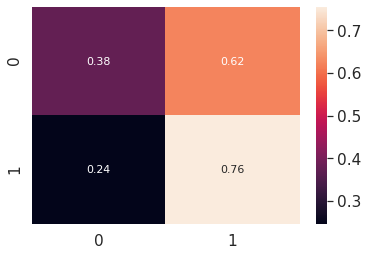

In [143]:
predictions = predict(x_test, model)
labelList=["0", "1"]

from sklearn.metrics import confusion_matrix
test_Y = y_test_enc
test_Y_max=np.argmax(test_Y, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()

In [144]:
print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = labelList, zero_division=0))

Classification Report
               precision    recall  f1-score   support

           0       0.44      0.38      0.40       578
           1       0.71      0.76      0.73      1147

    accuracy                           0.63      1725
   macro avg       0.57      0.57      0.57      1725
weighted avg       0.62      0.63      0.62      1725



# Model with BiLSTM

In [147]:
inputs1 = Input(shape=(20,))
inputs2 = Input(shape=(20,))
shared_emb = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=20, trainable=False)
emb_1 = shared_emb(inputs1)
emb_2 = shared_emb(inputs2)

shared_lstm = Bidirectional(LSTM(300, activation='relu'))
lstm_1 = shared_lstm(emb_1)
lstm_2 = shared_lstm(emb_2)

merged = tf.keras.layers.concatenate([lstm_1, lstm_2])
output = Dense(2, activation='softmax')(merged)

model = Model(inputs=[inputs1, inputs2], outputs=output)
model.compile(loss=["categorical_crossentropy"], optimizer='adam', metrics=['accuracy'])
# model.summary()

model.fit([x_train_seqs_1, x_train_seqs_2],
          y_train_enc, 
          # callbacks=callbacks_list, 
          validation_data=([x_valid_seqs_1, x_valid_seqs_2], y_valid_enc),
          epochs=20, batch_size=32, verbose=1,shuffle=True)

Epoch 1/20
115/115 [==============================] - 30s 262ms/step - loss: 0.6031 - accuracy: 0.6854 - val_loss: 0.6222 - val_accuracy: 0.6618
Epoch 2/20
115/115 [==============================] - 30s 261ms/step - loss: 0.5805 - accuracy: 0.7061 - val_loss: 0.6208 - val_accuracy: 0.6691
Epoch 3/20
115/115 [==============================] - 30s 257ms/step - loss: 0.5735 - accuracy: 0.7208 - val_loss: 0.6082 - val_accuracy: 0.6789
Epoch 4/20
115/115 [==============================] - 30s 259ms/step - loss: 0.5534 - accuracy: 0.7293 - val_loss: 0.6030 - val_accuracy: 0.6838
Epoch 5/20
115/115 [==============================] - 29s 254ms/step - loss: 0.5191 - accuracy: 0.7410 - val_loss: 0.6262 - val_accuracy: 0.6789
Epoch 6/20
115/115 [==============================] - 30s 259ms/step - loss: 0.4985 - accuracy: 0.7628 - val_loss: 0.6093 - val_accuracy: 0.6789
Epoch 7/20
115/115 [==============================] - 30s 265ms/step - loss: 0.4683 - accuracy: 0.7822 - val_loss: 0.7893 - val_ac

[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 

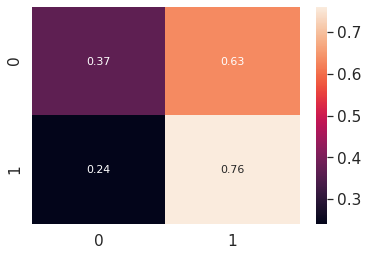

Classification Report
               precision    recall  f1-score   support

           0       0.44      0.37      0.40       578
           1       0.70      0.76      0.73      1147

    accuracy                           0.63      1725
   macro avg       0.57      0.56      0.56      1725
weighted avg       0.61      0.63      0.62      1725



In [148]:
predictions = predict(x_test, model)
labelList=["0", "1"]

from sklearn.metrics import confusion_matrix
test_Y = y_test_enc
test_Y_max=np.argmax(test_Y, axis=-1)
cm=confusion_matrix(test_Y_max,predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()

print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = labelList, zero_division=0))


# Task 2 Sentiment Classification
For this task we will be reusing the movie reviews dataset available on <a href="https://www.kaggle.com/c/word2vec-nlp-tutorial/data">kaggle</a> and download the dataset from there. 
We will be using the unlabeledTrainData file and labeledTrainData file. We will use the gensim package to train word2vec embeddings using [gensim](https://radimrehurek.com/gensim/) package and unlabelled train data as in the previous assignmnet. Now instead for creating a single representation for each review we will be using deep learning models for this task. We will use the same archetecture as before but will experiment with different reccurant networks namely RNN, GRU and LSTM.<br> This task might feel like <a href="https://ibb.co/Tgh2XyH">this</a> but since this is a deep learning assignment thus we must use it.
<h3>Data Preperation</h3>
<ul>
    <li> First we need to preprocess the data, convert the data to lower casing(both files). Any other preprocessing procedures are optional but keep in mind that this will affect the performance of your model.</li>
    <li> Split the labeledTrainData data file into test, train and validation in the ratio 20,70,10. Use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">scikit_test_train_split</a> <br><i><b>Hint:</b> use the splitter twice to get desired data splits.</i></li>
    <li> Next we need the vocabulary, vocabulary size and to convert sentences to numeric sequences by representing each word with a numeric value which will make our implementation easier later on, use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">Tokenizer</a> from keras. <br><i>(Fit the tokenizer on train data and use the same tokenizer to convert train,test and validation data to numeric sequences)</i> </li>
    <li>  Use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences"> pad sequences</a> to add post padding to all sentences that are shorter than maximum sequence length</li>
    <li> Use one hot representation for targets/labels, you can use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">scikit learn</a> or <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing">keras preprocessing</a>.</li>
</ul>
<h3>Loading embeddings</h3>
<ul>
    <li> As state before use the gensim package to train the word2vec model on unlabelledTrainData file</li>
    <li> Next we will create a dictionary for our dataset's vocabulary. Copy all the word embeddings for words that are in our vocabulary and in the word2vec model, if a word exists in our vocabulary but does not exist in word2vec model create a zero vector of embedding dimension size and add it to the dictionary.</li>
</ul>
<h3>Create Model</h3>
<ul>
    <li> Here is a visual for the model <img src="sentimentdeep.png">
    <li> Create the model using <a href"https://www.tensorflow.org/guide/keras/functional">functional API</a> or the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential">Sequential API</a></li>
    <li> Hints: The emebedding layer has a parameter that allows you to use pretrained embeddings</li>



Use can reuse the code snippets from above for call backs, prediction heat map and classification report
<i>You will have provide a label list for this specific dataset inorder for them to run, you are to make the required changes yourself</i>

In [0]:
# !unzip "/content/drive/My Drive/Colab Notebooks/labeledTrainData.tsv.zip"
# !unzip "/content/drive/My Drive/Colab Notebooks/unlabeledTrainData.tsv.zip"

Archive:  /content/drive/My Drive/Colab Notebooks/labeledTrainData.tsv.zip
  inflating: labeledTrainData.tsv    
Archive:  /content/drive/My Drive/Colab Notebooks/unlabeledTrainData.tsv.zip
  inflating: unlabeledTrainData.tsv  


In [0]:
import re
def preprocess(tweet):
    processed_data = tweet.lower()
    processed_data = re.sub("@[\S]+", "AT_TOKEN", processed_data)
    processed_data = re.sub("[#]", "", processed_data)
    processed_data = re.sub("<.*>", "", processed_data)
    processed_data = re.sub("[^a-zA-Z0-9\s_]", " ", processed_data)
    processed_data = re.sub("[\s]+", " ", processed_data)
    processed_data = re.sub("[_]{2,10}", "", processed_data)
    processed_data = processed_data.split(" ")
    return [x for x in processed_data if len(x) > 2]

In [0]:
import pandas as pd
data = pd.read_csv("unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
unlabaled_reviews = [preprocess(x) for x in data['review']]

data = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
X = [preprocess(x) for x in data['review']]
Y = [str(x) for x in data['sentiment']]

In [151]:
def get_distribution(data):
  dist = {}
  for point in data:
    for token in point:
      if token in dist:
        dist[token] += 1
      else: dist[token] = 1
  return dist
def handle_unks(data):
  dist = get_distribution(data)
  print(len(dist))
  for i, point in enumerate(data):
    for j, token in enumerate(point):
      if dist[token] == 1:
        data[i][j] = 'UNK'
  return data

unlabaled_reviews = handle_unks(unlabaled_reviews)

81138


In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.125, random_state=0)

In [0]:
import gensim
def trainWord2Vec(data):
  """
  Return preprocessed data

  Args:
      data : movie reviews

  Returns: model
  model : Word2Vec model 
  """
  emb_len = 300
  model = gensim.models.Word2Vec(sentences=data, size = emb_len, window=2, min_count=1)
  return model
w2v_model = trainWord2Vec(unlabaled_reviews)

In [154]:
#making a dictionary
embeddings_dictionary = {}
for review in unlabaled_reviews:
  for word in review:
    if word not in embeddings_dictionary:
      if word in w2v_model.wv:
        embeddings_dictionary[word] = w2v_model.wv[word]
      else:
        embeddings_dictionary[word] = [0]*300
print(len(embeddings_dictionary))

49304


In [155]:
tokenizer = Tokenizer(oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

#load pretrained embeddings
EMBEDDING_DIM = 300
embeddings_index = embeddings_dictionary

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
print(embedding_matrix.shape)
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector

(50733, 300)


In [0]:
def transform(tmp):
  train_seqs = tokenizer.texts_to_sequences([tmp])
  padded_seqs = pad_sequences(train_seqs, padding='post', maxlen=20)
  res = padded_seqs[0]
  return res
def transform_data(tmp):
  res = []
  for p in tmp:
    res += [transform(p)]
  return res
x_train_seqs = np.array(transform_data(x_train))
x_test_seqs = np.array(transform_data(x_test))
x_valid_seqs = np.array(transform_data(x_valid))

In [157]:
print(x_train_seqs.shape)

(17500, 20)


In [0]:
encod = {
    "1": [0, 1],
    "0": [1, 0]
}
y_train_enc = np.array([encod[x] for x in y_train], dtype=np.uint8)
y_valid_enc = np.array([encod[x] for x in y_valid], dtype=np.uint8)
y_test_enc = np.array([encod[x] for x in y_test], dtype=np.uint8)

In [159]:
print(y_test_enc.shape)

(5000, 2)


In [160]:
def make_model(rec_layer):
  inputs1 = Input(shape=(20,))
  emb = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=20, trainable=False)
  emb_1 = emb(inputs1)

  # lstm = LSTM(300, activation='relu')
  # lstm_1 = lstm(emb_1)
  recurrent_layer = rec_layer(emb_1)

  output = Dense(2, activation='softmax')(recurrent_layer)

  model = Model(inputs=inputs1, outputs=output)
  model.compile(loss=["categorical_crossentropy"], optimizer='adam', metrics=['accuracy'])
  model.summary()
  model.fit(x_train_seqs,
            y_train_enc, 
            # callbacks=callbacks_list, 
            validation_data=(x_valid_seqs, y_valid_enc),
            epochs=10, batch_size=32, verbose=1,shuffle=True)
  return model

lstm_model = make_model(LSTM(100, activation='relu'))
gru_model = make_model(GRU(100, activation='relu'))
rnn_model = make_model(SimpleRNN(100, activation='relu'))

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 20, 300)           15219900  
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 202       
Total params: 15,380,502
Trainable params: 160,602
Non-trainable params: 15,219,900
_________________________________________________________________
Epoch 1/10
547/547 [==============================] - 16s 29ms/step - loss: 0.5555 - accuracy: 0.7051 - val_loss: 0.5190 - val_accuracy: 0.7336
Epoch 2/10
547/547 [==============================] - 16s 29ms/step - loss: 0.4999 - accuracy:

In [0]:
def maxInd(x):
  if x[0] > x[1]:
    return 0
  return 1
def predict(data, inp_model):
  x_test_seqs = np.array(transform_data(data))
  print(x_test_seqs.shape)
  res = inp_model.predict(x_test_seqs)
  res = [maxInd(x) for x in res]
  print(np.array(res).shape)
  return res

In [0]:
def report(inp_model):
  predictions = predict(x_test, inp_model)
  labelList=["0", "1"]

  from sklearn.metrics import confusion_matrix
  test_Y = y_test_enc
  test_Y_max=np.argmax(test_Y, axis=-1)
  cm=confusion_matrix(test_Y_max,predictions)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  print(cm)
  cm = pd.DataFrame(cm, labelList,labelList )# matrix,names row,names col,
  # plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
  plt.show()
  print("Classification Report\n",classification_report(test_Y_max, predictions, labels=[0,1], target_names = labelList, zero_division=0))


For RNN
(5000, 20)
(5000,)
[[0.70839874 0.29160126]
 [0.26264274 0.73735726]]


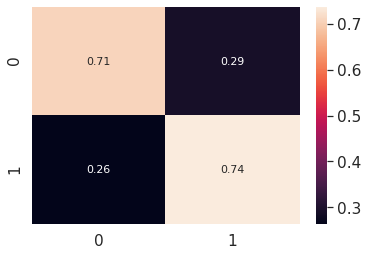

Classification Report
               precision    recall  f1-score   support

           0       0.74      0.71      0.72      2548
           1       0.71      0.74      0.72      2452

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



In [163]:
print("For RNN")
report(rnn_model)

For LSTM
(5000, 20)
(5000,)
[[0.67582418 0.32417582]
 [0.22634584 0.77365416]]


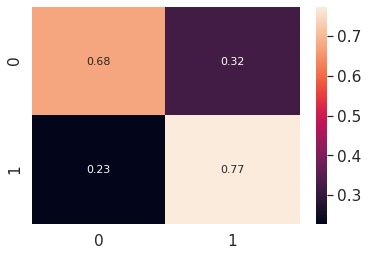

Classification Report
               precision    recall  f1-score   support

           0       0.76      0.68      0.71      2548
           1       0.70      0.77      0.73      2452

    accuracy                           0.72      5000
   macro avg       0.73      0.72      0.72      5000
weighted avg       0.73      0.72      0.72      5000



In [164]:
print("For LSTM")
report(lstm_model)

For GRU
(5000, 20)
(5000,)
[[0.76255887 0.23744113]
 [0.27732463 0.72267537]]


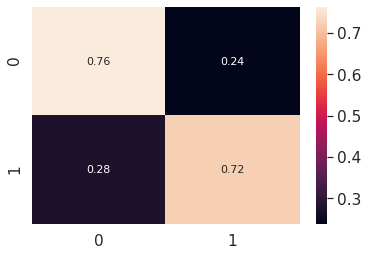

Classification Report
               precision    recall  f1-score   support

           0       0.74      0.76      0.75      2548
           1       0.75      0.72      0.73      2452

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000



In [165]:
print("For GRU")
report(gru_model)

# We hope all of you are working on your projects and <a href="https://ibb.co/dcpf4vS"> Kudos for completing the assingnment</a>